<a href="https://colab.research.google.com/github/Slrosales/Colombianos-detenidos-en-el-exterior/blob/main/ML_Colombianos_detenidos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataframe Colombianos detenidos en el exterior - Datos categóricos**

# Importación e instalación de librerías

In [ ]:
!pip install ucimlrepo
!pip install kmodes
!pip install umap-learn
!pip install pandas scikit-learn imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from kmodes.kmodes import KModes
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

import prince
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, cohen_kappa_score

# Configuraciones opcionales para mejor visualización
plt.style.use('ggplot') # Un estilo visual agradable
pd.set_option('display.max_columns', None) # Mostrar todas las columnas

# Importacón del dataset

In [ ]:
df = pd.read_csv('/content/col_det_clean.csv');

df.head(5)

<ipython-input-5-71c9756aaff4>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/col_det_clean.csv');


,FECHA PUBLICACIÓN,PAIS PRISIÓN,DELITO,EXTRADITADO Y O REPATRIADO,SITUACIÓN JURÍDICA,GÉNERO,GRUPO EDAD,UBICACIÓN PAÍS,CANTIDAD,LATITUD,LONGITUD,MES,AÑO
0,2018-09-17,ECUADOR,NARCOTRÁFICO,DESCONOCIDO,EN JUICIO,MASCULINO,DESCONOCIDO,"(-1.831239, -78.183406)",45,-1.831239,-78.183406,9,2018
1,2018-09-17,ITALIA,OTRO,DESCONOCIDO,EN INVESTIGACIÓN,MASCULINO,DESCONOCIDO,"(41.87194, 12.56738)",1,41.871940,12.567380,9,2018
2,2018-09-17,ESTADOS UNIDOS,EXTORSIÓN,DESCONOCIDO,CONDENADO,MASCULINO,ADULTO,"(37.09024, -95.712891)",1,37.090240,-95.712891,9,2018
3,2018-09-17,MÉXICO,OTRO,DESCONOCIDO,EN INVESTIGACIÓN,MASCULINO,ADULTO JOVEN,"(23.634501, -102.552784)",7,23.634501,-102.552784,9,2018
4,2018-09-17,JAPÓN,ROBO,DESCONOCIDO,CONDENADO,FEMENINO,ADULTO MAYOR,"(36.204824, 138.252924)",1,36.204824,138.252924,9,2018


In [ ]:
df_colombianos_presos = df.copy()

# Limpieza dataset

In [ ]:
df_colombianos_presos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330492 entries, 0 to 330491
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FECHA PUBLICACIÓN           330492 non-null  object 
 1   PAIS PRISIÓN                330492 non-null  object 
 2   DELITO                      330492 non-null  object 
 3   EXTRADITADO Y O REPATRIADO  330492 non-null  object 
 4   SITUACIÓN JURÍDICA          330492 non-null  object 
 5   GÉNERO                      330492 non-null  object 
 6   GRUPO EDAD                  330492 non-null  object 
 7   UBICACIÓN PAÍS              121588 non-null  object 
 8   CANTIDAD                    330492 non-null  int64  
 9   LATITUD                     286374 non-null  float64
 10  LONGITUD                    286374 non-null  float64
 11  MES                         330492 non-null  int64  
 12  AÑO                         330492 non-null  int64  
dtypes: float64(2),

In [ ]:
menores = ['PRIMERA INFANCIA', 'ADOLESCENTE', 'INFANTE']

df_colombianos_presos['GRUPO EDAD'] = df_colombianos_presos['GRUPO EDAD'].apply(
    lambda x: 'MENORES' if x in menores else x
)

In [ ]:
genero = ['NO_BINARIO']

df_colombianos_presos['GÉNERO'] = df_colombianos_presos['GÉNERO'].apply(
    lambda x: 'OTRO' if x in genero else x
)

In [ ]:
df_colombianos_presos = df_colombianos_presos[df_colombianos_presos['DELITO'] != 'OTRO']
df_colombianos_presos = df_colombianos_presos[df_colombianos_presos['DELITO'] != 'NO REPORTA']

In [ ]:
df_colombianos_presos = df_colombianos_presos[df_colombianos_presos['GRUPO EDAD'] != 'DESCONOCIDO']
df_colombianos_presos['GRUPO EDAD'].unique()

array(['ADULTO', 'ADULTO MAYOR', 'MENORES', 'ADULTO JOVEN'], dtype=object)

In [ ]:
select2 = ['PAIS PRISIÓN', 'CANTIDAD']
groups2 = ['PAIS PRISIÓN']

pais_mayor_detencion_2 = df_colombianos_presos[select2].groupby(by = groups2).sum()
pais_mayor_detencion_2 = pais_mayor_detencion_2.sort_values(by = 'CANTIDAD', ascending = False)
pais_mayor_detencion_2.reset_index(inplace = True)
pais_mayor_detencion_2.head(15)

,PAIS PRISIÓN,CANTIDAD
0,ESTADOS UNIDOS,166311
1,ESPAÑA,137586
2,VENEZUELA,101388
3,ECUADOR,70135
4,CHILE,61910
5,PANAMÁ,50130
6,PERÚ,42836
7,MÉXICO,33436
8,COSTA RICA,19873
9,COLOMBIA,18067


In [ ]:
paises_frecuentes = pais_mayor_detencion_2[pais_mayor_detencion_2['CANTIDAD'] > 10000]['PAIS PRISIÓN']

paises_frecuentes_lista = paises_frecuentes.tolist()

df_colombianos_presos = df_colombianos_presos[df_colombianos_presos['PAIS PRISIÓN'].isin(paises_frecuentes_lista)]
df_colombianos_presos.reset_index(drop = True, inplace = True)
df_colombianos_presos.head()

,FECHA PUBLICACIÓN,PAIS PRISIÓN,DELITO,EXTRADITADO Y O REPATRIADO,SITUACIÓN JURÍDICA,GÉNERO,GRUPO EDAD,UBICACIÓN PAÍS,CANTIDAD,LATITUD,LONGITUD,MES,AÑO
0,2018-09-17,ESTADOS UNIDOS,EXTORSIÓN,DESCONOCIDO,CONDENADO,MASCULINO,ADULTO,"(37.09024, -95.712891)",1,37.09024,-95.712891,9,2018
1,2018-09-17,ITALIA,ROBO,DESCONOCIDO,EN JUICIO,MASCULINO,ADULTO,"(41.87194, 12.56738)",1,41.87194,12.567380,9,2018
2,2018-09-17,ESTADOS UNIDOS,DELITO MIGRATORIO,DESCONOCIDO,EN INVESTIGACIÓN,MASCULINO,ADULTO,"(37.09024, -95.712891)",1,37.09024,-95.712891,9,2018
3,2018-09-17,VENEZUELA,HOMICIDIO,DESCONOCIDO,EN JUICIO,MASCULINO,ADULTO,"(6.42375, -66.58973)",2,6.42375,-66.589730,9,2018
4,2018-09-17,VENEZUELA,ROBO,DESCONOCIDO,CONDENADO,MASCULINO,MENORES,"(6.42375, -66.58973)",1,6.42375,-66.589730,9,2018


In [ ]:
df_colombianos_presos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159695 entries, 0 to 159694
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FECHA PUBLICACIÓN           159695 non-null  object 
 1   PAIS PRISIÓN                159695 non-null  object 
 2   DELITO                      159695 non-null  object 
 3   EXTRADITADO Y O REPATRIADO  159695 non-null  object 
 4   SITUACIÓN JURÍDICA          159695 non-null  object 
 5   GÉNERO                      159695 non-null  object 
 6   GRUPO EDAD                  159695 non-null  object 
 7   UBICACIÓN PAÍS              59040 non-null   object 
 8   CANTIDAD                    159695 non-null  int64  
 9   LATITUD                     140005 non-null  float64
 10  LONGITUD                    140005 non-null  float64
 11  MES                         159695 non-null  int64  
 12  AÑO                         159695 non-null  int64  
dtypes: float64(2),

## Analisis exploratorio

### Top 5 de relación del número de presos con el país donde están recluidos

In [ ]:
select2 = ['PAIS PRISIÓN', 'CANTIDAD']
groups2 = ['PAIS PRISIÓN']

pais_mayor_detencion = df_colombianos_presos[select2].groupby(by = groups2).sum()

pais_mayor_detencion = pais_mayor_detencion.sort_values(by = 'CANTIDAD', ascending = False)

pais_mayor_detencion.reset_index(inplace = True)

pais_mayor_detencion.head(15)

,PAIS PRISIÓN,CANTIDAD
0,ESTADOS UNIDOS,166311
1,ESPAÑA,137586
2,VENEZUELA,101388
3,ECUADOR,70135
4,CHILE,61910
5,PANAMÁ,50130
6,PERÚ,42836
7,MÉXICO,33436
8,COSTA RICA,19873
9,COLOMBIA,18067


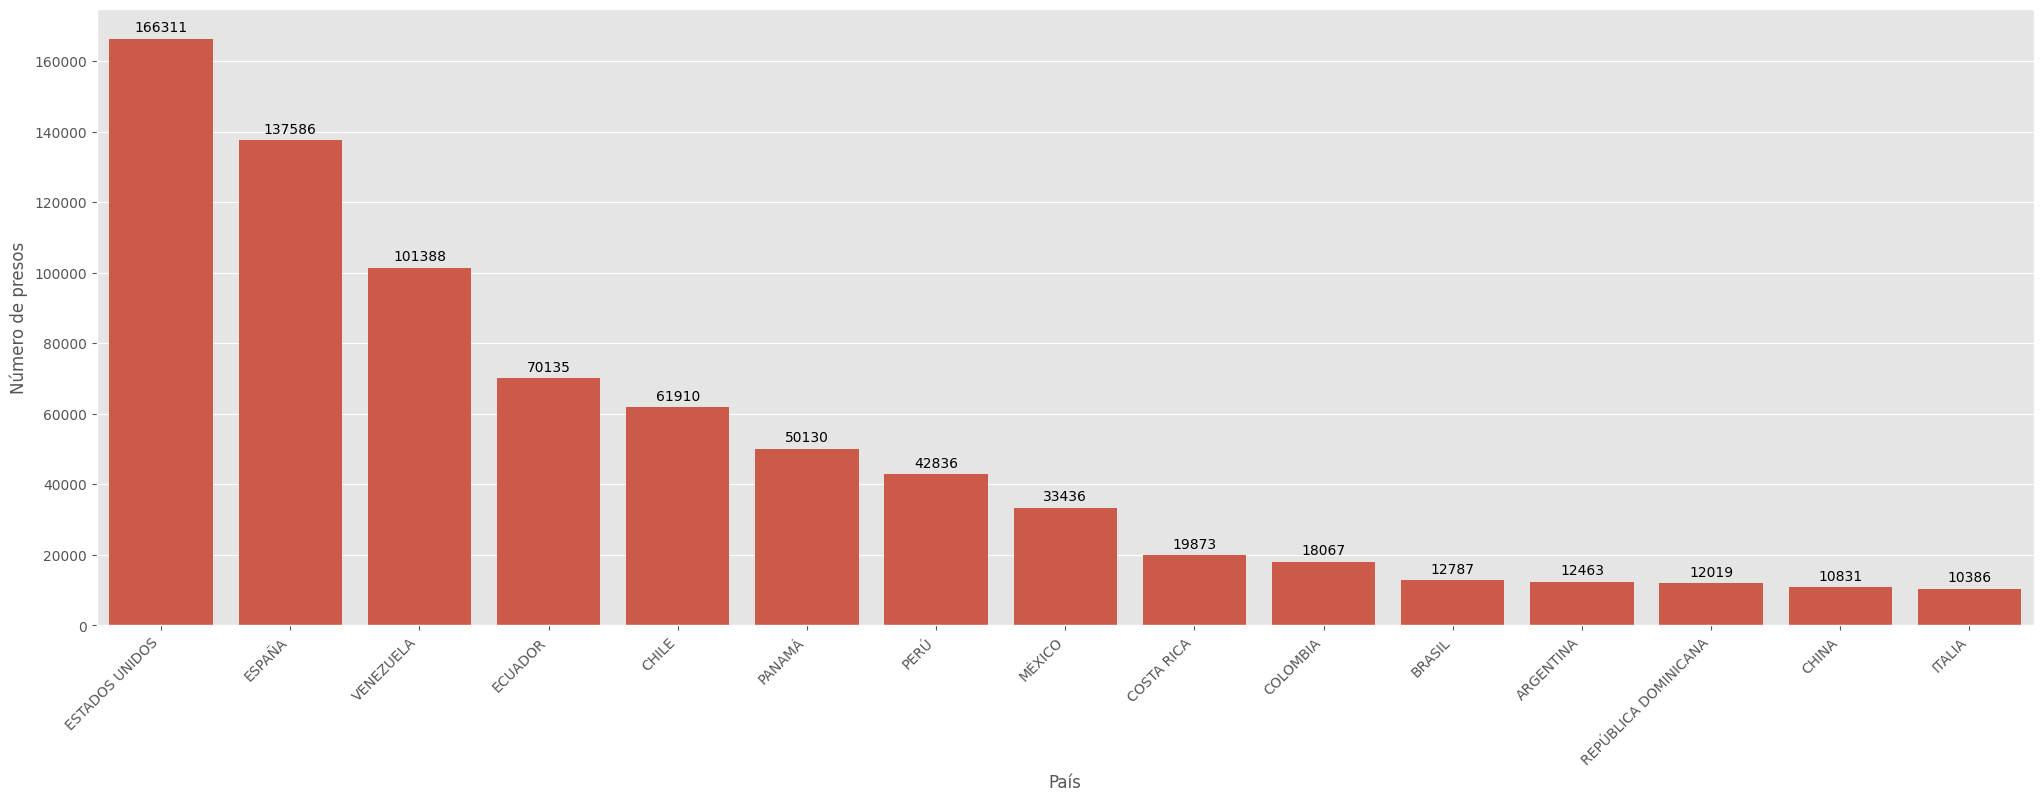

In [ ]:
plt.figure(figsize=(25,8))
barplot = sns.barplot(data = pais_mayor_detencion.head(15), x = "PAIS PRISIÓN", y = "CANTIDAD")
plt.ylabel('Número de presos')
plt.xlabel('País')
plt.xticks(rotation = 45, ha = 'right')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'baseline',
                     fontsize=10, color='black', xytext = (0, 5),
                     textcoords = 'offset points')
plt.show()

**Las mayores tasas de detención se producen en países con moneda de alto valor**

Las tasas de detención de colombianos en el exterior son más frecuentes en España (42774), seguido por Estados Unidos (37960), Venezuela (31828), Ecuador (14686) y Chile (14681).
A excepción de Venezuela, estos países son en parte dominantes en el mundo por
el valor de su moneda (euro / dólar); ya que con una de estas se puede obtener más de 4000 veces lo que se adquiere con otras, como el peso colombiano. Cabe recalcar que tanto Venezuela como Ecuador son países fronterizos que facilitarían actos delictivos como el contrabando.

### Top 10 de relación del número de presos con respecto al tipo de delito cometido

In [ ]:
paises_con_mas_detenidos = df_colombianos_presos.groupby('PAIS PRISIÓN')['CANTIDAD'].sum()
paises_con_mas_detenidos = paises_con_mas_detenidos.sort_values(ascending=False).head(5)
top_5_paises_lista = paises_con_mas_detenidos.index.tolist()

df_filtrado_top_paises = df_colombianos_presos[df_colombianos_presos['PAIS PRISIÓN'].isin(top_5_paises_lista)]

delitos_mas_detenidos = df_colombianos_presos.groupby('DELITO')['CANTIDAD'].sum()
delitos_mas_detenidos = delitos_mas_detenidos.sort_values(ascending=False).head(5)
top_5_delito_lista = delitos_mas_detenidos.index.tolist()

df_filtrado_top_paises = df_colombianos_presos[df_colombianos_presos['DELITO'].isin(top_5_delito_lista)]

select3 = ['DELITO', 'PAIS PRISIÓN', 'CANTIDAD']
groups3 = ['PAIS PRISIÓN', 'DELITO']

delitos_en_top_paises = df_filtrado_top_paises[select3].groupby(by=groups3, observed=False).sum()

delitos_en_top_paises = delitos_en_top_paises.reset_index()

delitos_en_top_paises['PAIS PRISIÓN'] = pd.Categorical(
    delitos_en_top_paises['PAIS PRISIÓN'],
    categories=top_5_paises_lista,
    ordered=True
)

delitos_en_top_paises = delitos_en_top_paises.sort_values(
    by=['PAIS PRISIÓN', 'CANTIDAD'],
    ascending=[True, False]
)

delitos_en_top_paises.head()

,PAIS PRISIÓN,DELITO,CANTIDAD
40,ESTADOS UNIDOS,NARCOTRÁFICO,118750
39,ESTADOS UNIDOS,HOMICIDIO,10051
42,ESTADOS UNIDOS,ROBO,9051
38,ESTADOS UNIDOS,DELITOS SEXUALES,8200
41,ESTADOS UNIDOS,PORTE ILEGAL DE ARMAS,1893


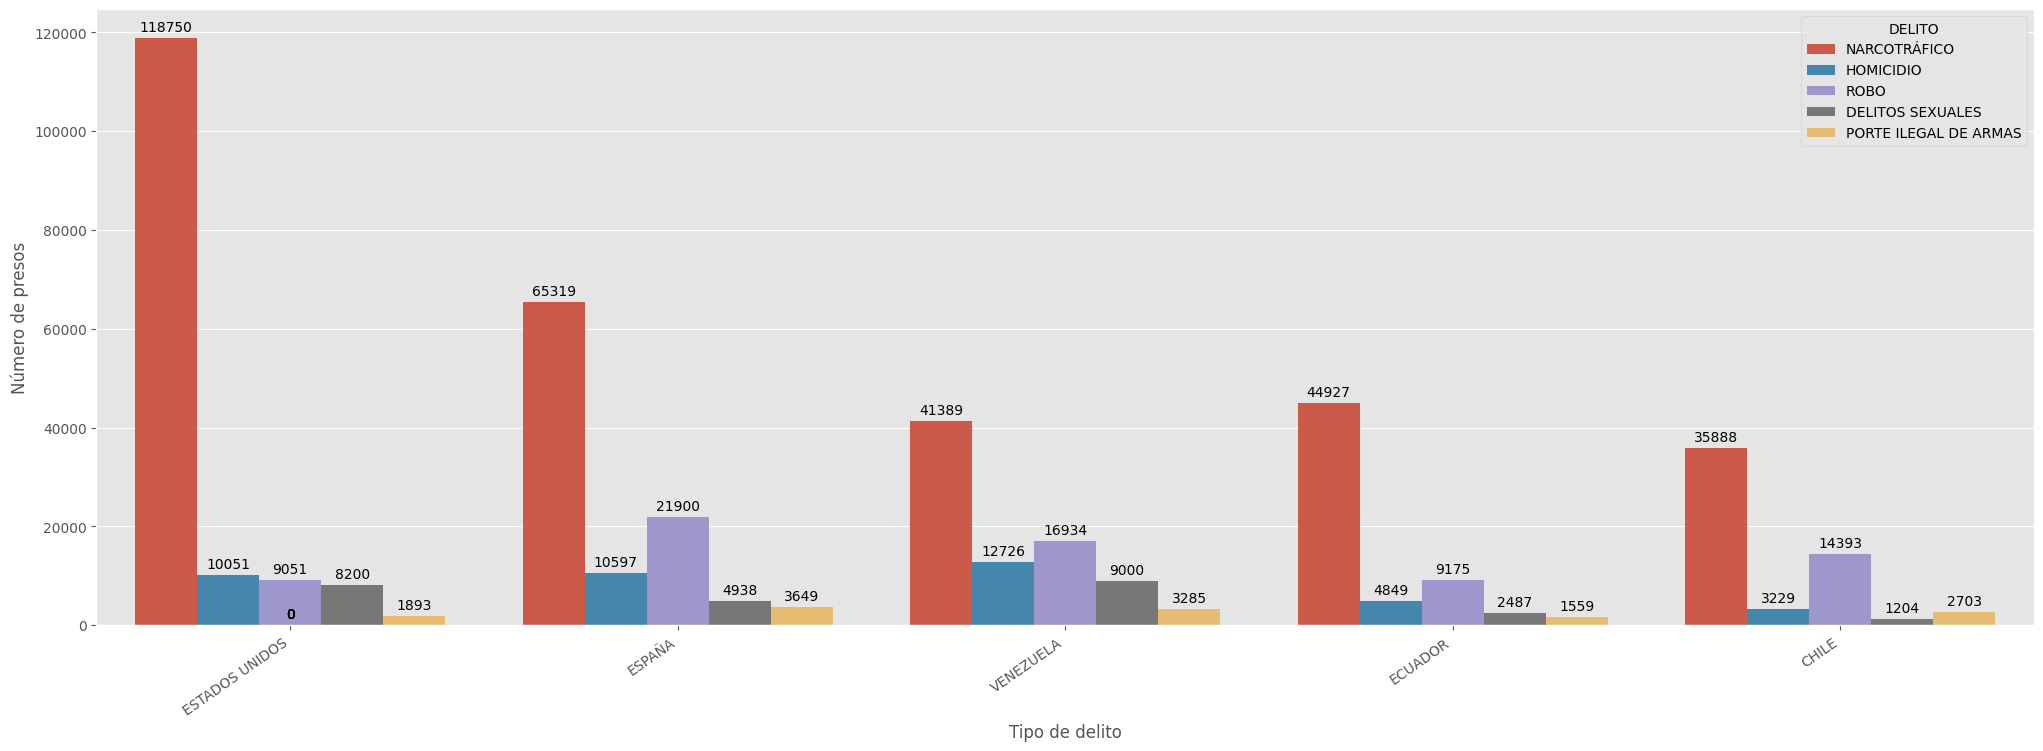

In [ ]:
plt.figure(figsize=(25,8))
barplot = sns.barplot(data = delitos_en_top_paises, x = "PAIS PRISIÓN", y = "CANTIDAD", hue='DELITO');
plt.ylabel('Número de presos');
plt.xlabel('Tipo de delito');
plt.xticks(rotation = 35, ha = 'right')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'baseline',
                     fontsize=10, color='black', xytext = (0, 5),
                     textcoords = 'offset points')

plt.show()

**El delito por el que mayormente son detenidos los colombianos en el exterior es el narcotráfico**

El tipo de delito con mayor tendencia a ser causa de reclusión es el narcotráfico destacando los 5 países anteriormente mencionados.
La razón de esto está ligada al pasado histórico de Colombia en el mercado de las drogas, debido a que es una de las naciones que más practica este acto, siendo “Colombia la que mantuvo su posición como la principal nación refinadora de cocaína, al proporcionar cerca del 80% (220 toneladas métricas) del total de las importaciones de cocaína (aproximadamente 300 toneladas métricas) introducidas a los Estados Unidos en 1999” (Bailey, 2015, p.2).

### Relación del número de presos con respecto al rango edad cuando cometen un delito

In [ ]:
select4 = ['GRUPO EDAD', 'CANTIDAD']
groups4 = ['GRUPO EDAD']

edades_con_mas_delitos = df_colombianos_presos[select4].groupby(by = groups4).sum()

edades_con_mas_delitos = edades_con_mas_delitos.sort_values(by = 'CANTIDAD', ascending = False)

edades_con_mas_delitos.reset_index(inplace = True)

edades_con_mas_delitos

,GRUPO EDAD,CANTIDAD
0,ADULTO,582246
1,ADULTO JOVEN,90307
2,ADULTO MAYOR,85356
3,MENORES,2249


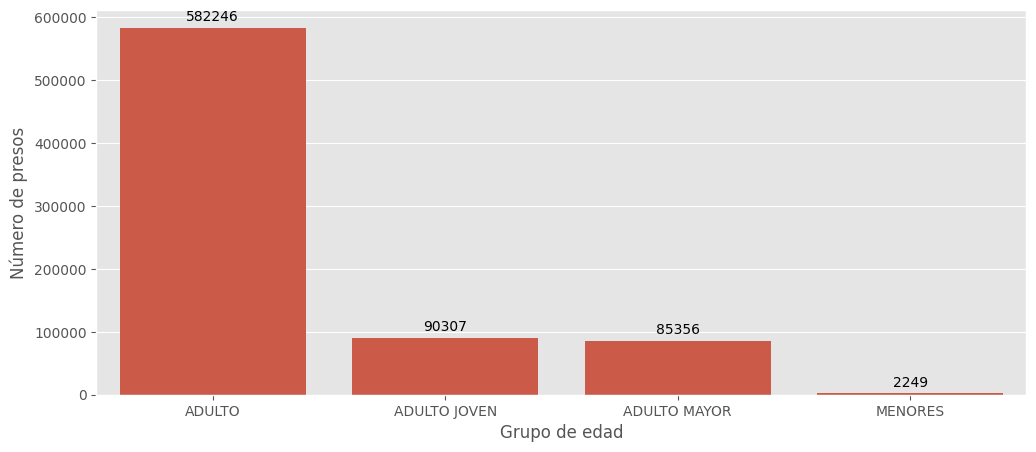

In [ ]:
plt.figure(figsize=(12,5))
barplot = barpplot = sns.barplot(data = edades_con_mas_delitos, x = "GRUPO EDAD", y = "CANTIDAD")
plt.ylabel('Número de presos')
plt.xlabel('Grupo de edad')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'baseline',
                     fontsize=10, color='black', xytext = (0, 5),
                     textcoords = 'offset points')

plt.show()

**El rango de edad más frecuente de los colombianos detenidos es la adultez**

Se puede apreciar que la mayor cantidad de personas detenidas corresponde a un rango de edad entre los 27 y los 59 años, siendo considerado como la adultez.

### Relación del número de presos con respecto al género de quienes cometen el delito

In [ ]:
select5 = ['GÉNERO', 'CANTIDAD']
groups5 = ['GÉNERO']

generos = df_colombianos_presos[select5].groupby(by = groups5).sum()

generos = generos.sort_values(by = 'CANTIDAD', ascending = False)

generos.reset_index(inplace = True)

generos

,GÉNERO,CANTIDAD
0,MASCULINO,673007
1,FEMENINO,86913
2,OTRO,238


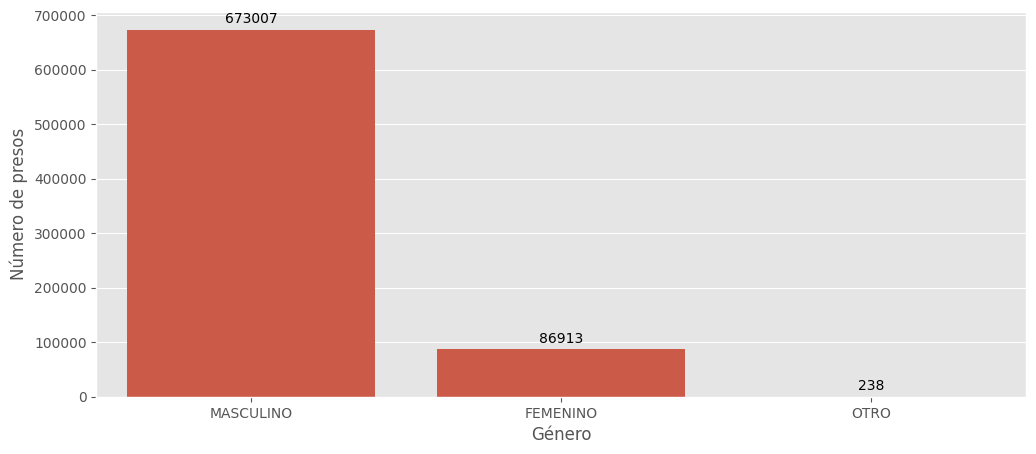

In [ ]:
plt.figure(figsize=(12,5))
barplot = sns.barplot(data = generos, x = "GÉNERO", y = "CANTIDAD")
plt.ylabel('Número de presos')
plt.xlabel('Género')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'baseline',
                     fontsize=10, color='black', xytext = (0, 5),
                     textcoords = 'offset points')

plt.show()

**Las detenciones en el exterior son más frecuentes para el género masculino**

# **Aprendizaje no supervisado**

In [ ]:
df_ml = df_colombianos_presos.copy()

In [ ]:
df_ml = df_ml[['DELITO', 'PAIS PRISIÓN', 'GRUPO EDAD', 'GÉNERO']]
df_ml.head()

,DELITO,PAIS PRISIÓN,GRUPO EDAD,GÉNERO
0,EXTORSIÓN,ESTADOS UNIDOS,ADULTO,MASCULINO
1,ROBO,ITALIA,ADULTO,MASCULINO
2,DELITO MIGRATORIO,ESTADOS UNIDOS,ADULTO,MASCULINO
3,HOMICIDIO,VENEZUELA,ADULTO,MASCULINO
4,ROBO,VENEZUELA,MENORES,MASCULINO


## Elegir K comparando el costo con cada K

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 332688.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 294576.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 281758.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 260598.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/

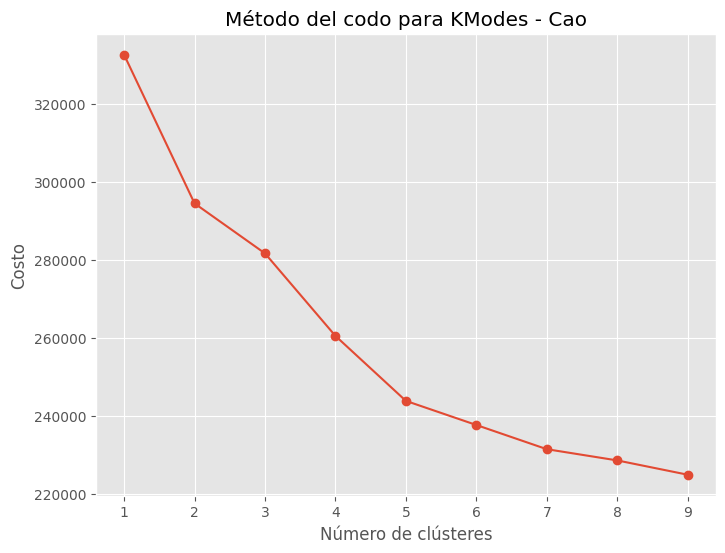

In [ ]:
k_range = list(range(1,10))
cost = []
for num_clusters in k_range:
    kmode = KModes(n_clusters=num_clusters, init='Cao', n_init=5, random_state=42, verbose=1)
    kmode.fit_predict(df_ml)
    cost.append(kmode.cost_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(k_range, cost, marker='o')
plt.xlabel("Número de clústeres")
plt.ylabel("Costo")
plt.title("Método del codo para KModes - Cao")
plt.xticks(k_range)
plt.grid(True)
plt.show()

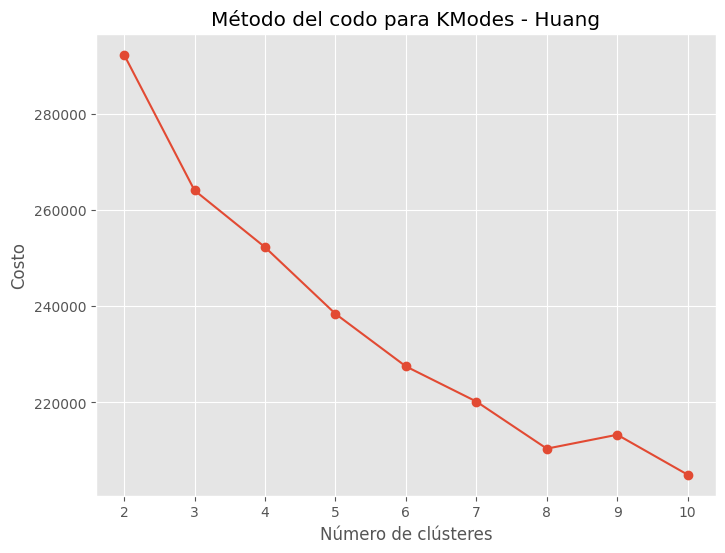

In [ ]:
# 3. Encontrar el número óptimo de clústeres (usando el método del codo)
cost = []
k_range = range(2, 11)

for k in k_range:
    km = KModes(n_clusters=k, init='Huang', n_init=5, random_state=42, verbose=0)
    km.fit(df_ml)
    cost.append(km.cost_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(k_range, cost, marker='o')
plt.xlabel("Número de clústeres")
plt.ylabel("Costo")
plt.title("Método del codo para KModes - Huang")
plt.xticks(k_range)
plt.grid(True)
plt.show()

Elegimos 4 clusters

## Cluster Kmode Cao

In [ ]:
km_cao = KModes(n_clusters=4, init='Cao', verbose=1, random_state=42)
clusters_cao = km_cao.fit_predict(df_ml)
clusters_cao

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 260598.0


array([0, 3, 0, ..., 0, 3, 1], dtype=uint16)

In [ ]:
df_cluster = df_ml.copy()

In [ ]:
df_cluster['cluster'] = clusters_cao
df_cluster = df_cluster.reset_index()
df_cluster = df_cluster.drop('index', axis=1)

df_cluster.head()

,DELITO,PAIS PRISIÓN,GRUPO EDAD,GÉNERO,cluster
0,EXTORSIÓN,ESTADOS UNIDOS,ADULTO,MASCULINO,0
1,ROBO,ITALIA,ADULTO,MASCULINO,3
2,DELITO MIGRATORIO,ESTADOS UNIDOS,ADULTO,MASCULINO,0
3,HOMICIDIO,VENEZUELA,ADULTO,MASCULINO,0
4,ROBO,VENEZUELA,MENORES,MASCULINO,0


In [ ]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159695 entries, 0 to 159694
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DELITO        159695 non-null  object
 1   PAIS PRISIÓN  159695 non-null  object
 2   GRUPO EDAD    159695 non-null  object
 3   GÉNERO        159695 non-null  object
 4   cluster       159695 non-null  uint16
dtypes: object(4), uint16(1)
memory usage: 5.2+ MB


--- Resumen de Clusters (Moda - Categoría Más Frecuente) ---
               DELITO    PAIS PRISIÓN    GRUPO EDAD     GÉNERO
cluster                                                       
0        NARCOTRÁFICO       VENEZUELA        ADULTO  MASCULINO
1                ROBO  ESTADOS UNIDOS  ADULTO JOVEN  MASCULINO
2           HOMICIDIO          ESPAÑA  ADULTO MAYOR  MASCULINO
3                ROBO          ESPAÑA        ADULTO  MASCULINO
------------------------------------------------------------
Resumen de moda guardado en cluster_mode_summary.csv y .xlsx
------------------------------------------------------------

--- Resumen de Clusters (Proporciones de Categorías) ---

Distribución para la característica: 'DELITO' (Numérico para guardar/graficar)
DELITO   ALLANAMIENTO  AMENAZAS  COACCIÓN  CONDUCCIÓN TEMERARIA  CONTRABANDO  \
cluster                                                                        
0            0.203173  0.966047  0.070329              0.309643     2.417559   


<ipython-input-64-e4cc0bbcc2d1>:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  feature_summary_formatted = feature_summary_numeric.applymap(lambda x: f"{x:.1f}%")


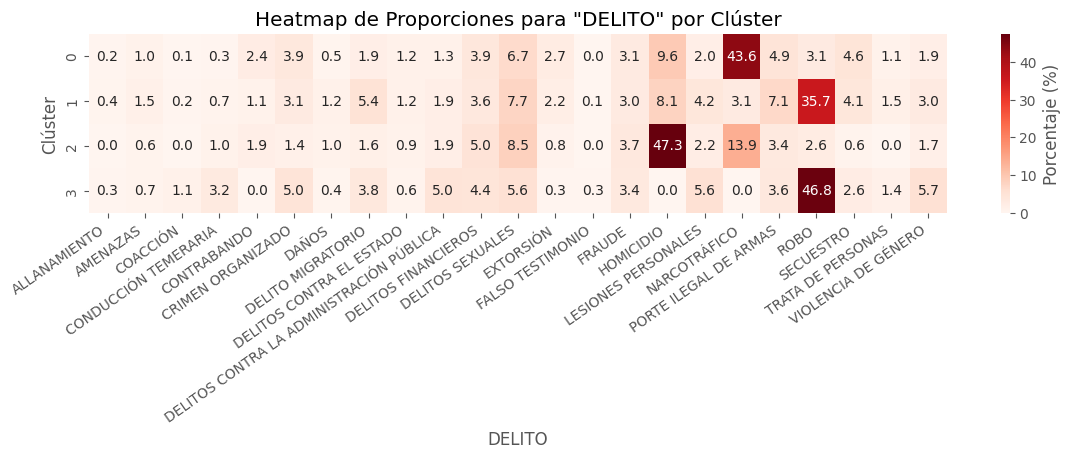

<ipython-input-64-e4cc0bbcc2d1>:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  feature_summary_formatted = feature_summary_numeric.applymap(lambda x: f"{x:.1f}%")



Distribución para la característica: 'PAIS PRISIÓN' (Numérico para guardar/graficar)
PAIS PRISIÓN  ARGENTINA    BRASIL     CHILE     CHINA  COLOMBIA  COSTA RICA  \
cluster                                                                       
0              1.736735  2.710596  5.820700  2.527936  3.929632    2.209502   
1              4.016252  2.613980  8.431612  0.970804  0.201352    2.258018   
2              1.090839  1.187373  2.809151  0.241336  1.930688    2.394053   
3              2.982035  3.786296  3.603510  0.783372  1.927094    2.021099   

PAIS PRISIÓN    ECUADOR     ESPAÑA  ESTADOS UNIDOS    ITALIA     MÉXICO  \
cluster                                                                   
0              8.585020   4.479566       18.422286  3.278112   5.716183   
1             11.214584  11.980440       32.036531  2.653531  10.268949   
2              7.317309  58.451588        8.079930  0.791582   1.679699   
3              5.624608  64.314811        0.000000  4.554000   6

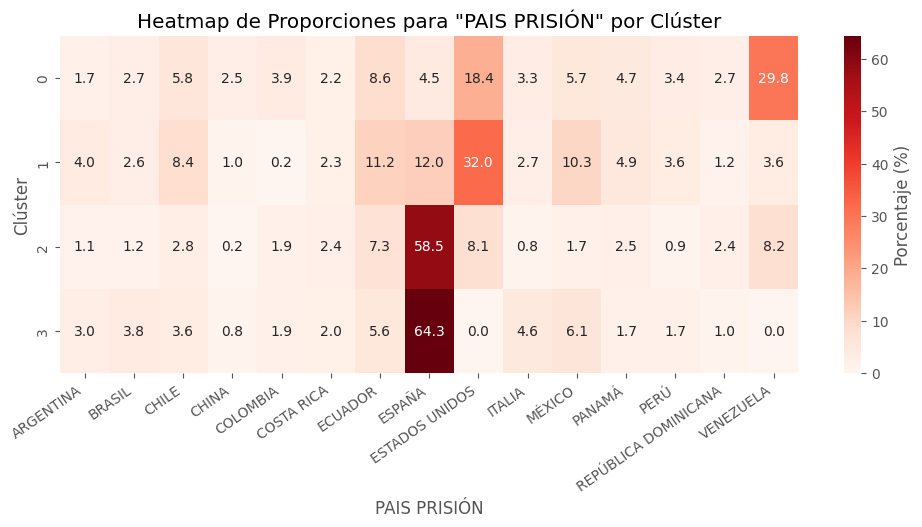

<ipython-input-64-e4cc0bbcc2d1>:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  feature_summary_formatted = feature_summary_numeric.applymap(lambda x: f"{x:.1f}%")



Distribución para la característica: 'GRUPO EDAD' (Numérico para guardar/graficar)
GRUPO EDAD     ADULTO  ADULTO JOVEN  ADULTO MAYOR   MENORES
cluster                                                    
0           75.110377     10.323709     13.233570  1.332344
1            5.296275     74.241335     18.430893  2.031497
2           17.270007      7.104933     75.074814  0.550246
3           99.362858      0.000000      0.000000  0.637142

Distribución para la característica: 'GRUPO EDAD' (Formateado para mostrar)
GRUPO EDAD ADULTO ADULTO JOVEN ADULTO MAYOR MENORES
cluster                                            
0           75.1%        10.3%        13.2%    1.3%
1            5.3%        74.2%        18.4%    2.0%
2           17.3%         7.1%        75.1%    0.6%
3           99.4%         0.0%         0.0%    0.6%
Proporciones para 'GRUPO EDAD' guardadas en proportions_grupo_edad.csv


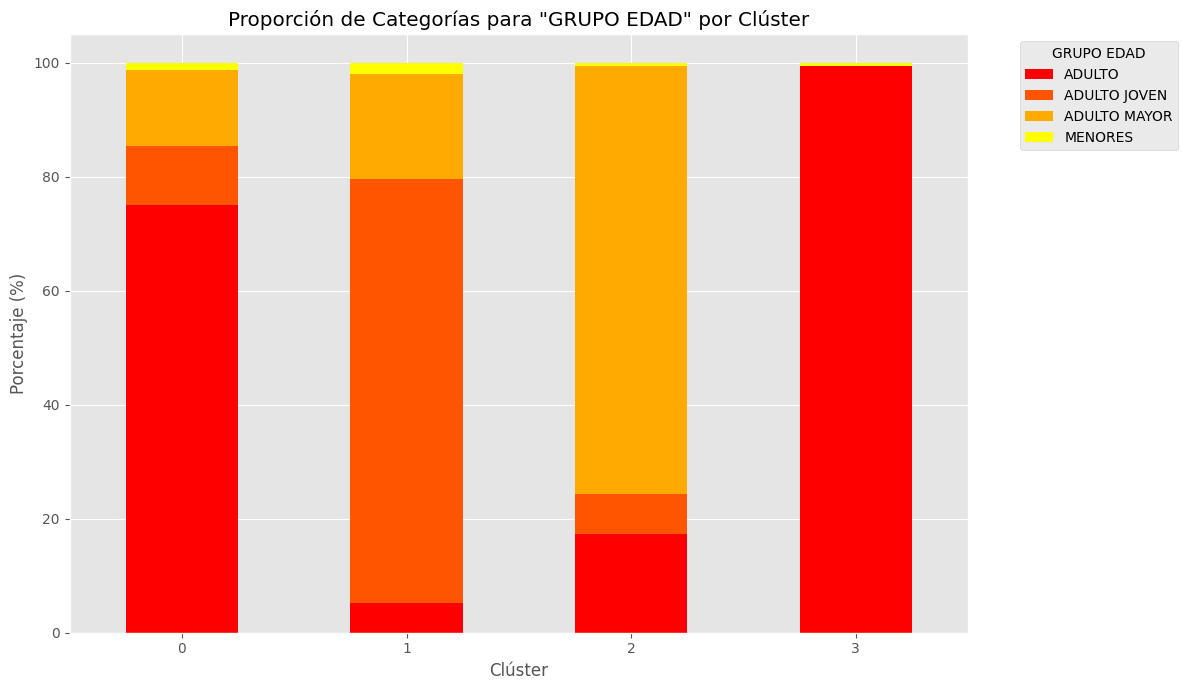

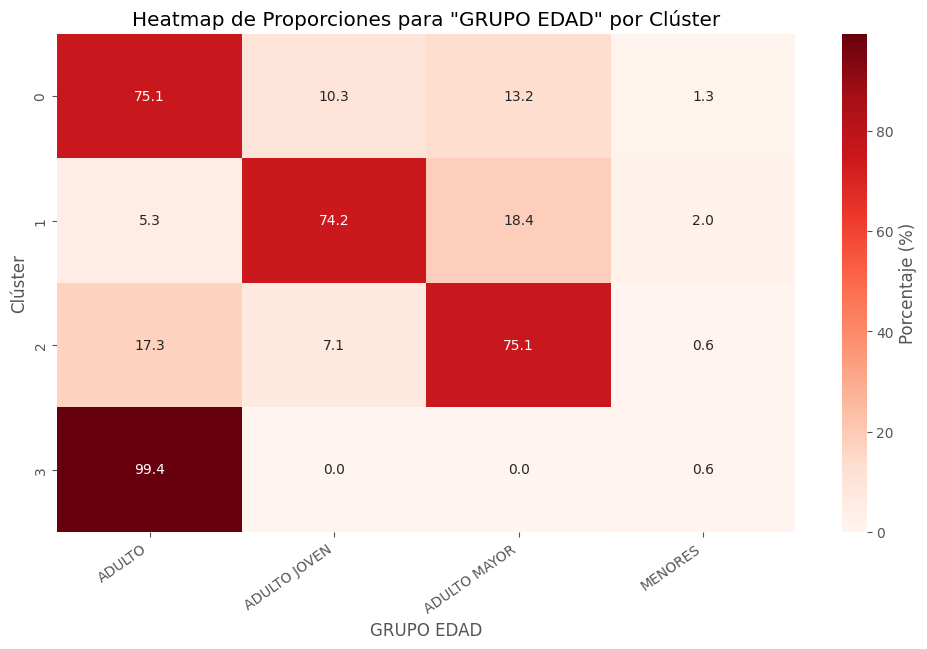

<ipython-input-64-e4cc0bbcc2d1>:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  feature_summary_formatted = feature_summary_numeric.applymap(lambda x: f"{x:.1f}%")



Distribución para la característica: 'GÉNERO' (Numérico para guardar/graficar)
GÉNERO    FEMENINO  MASCULINO      OTRO
cluster                                
0        20.890638  78.883723  0.225639
1        14.849705  85.150295  0.000000
2        16.488078  83.511922  0.000000
3        24.195738  75.767704  0.036557

Distribución para la característica: 'GÉNERO' (Formateado para mostrar)
GÉNERO  FEMENINO MASCULINO  OTRO
cluster                         
0          20.9%     78.9%  0.2%
1          14.8%     85.2%  0.0%
2          16.5%     83.5%  0.0%
3          24.2%     75.8%  0.0%
Proporciones para 'GÉNERO' guardadas en proportions_género.csv


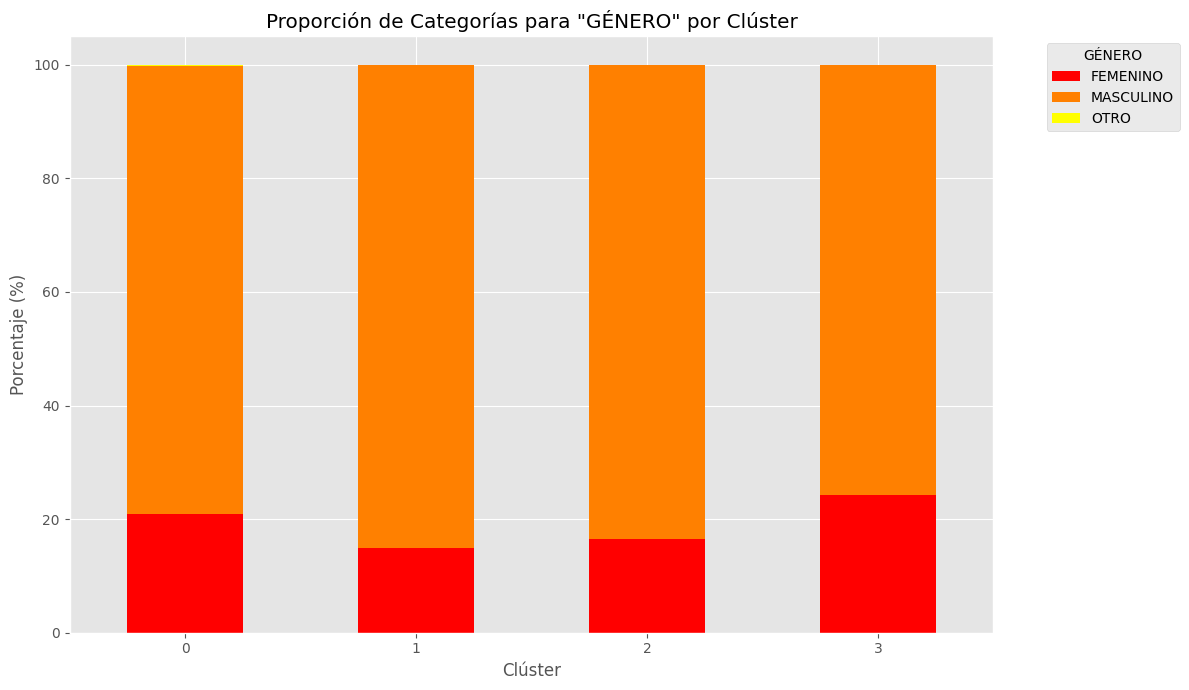

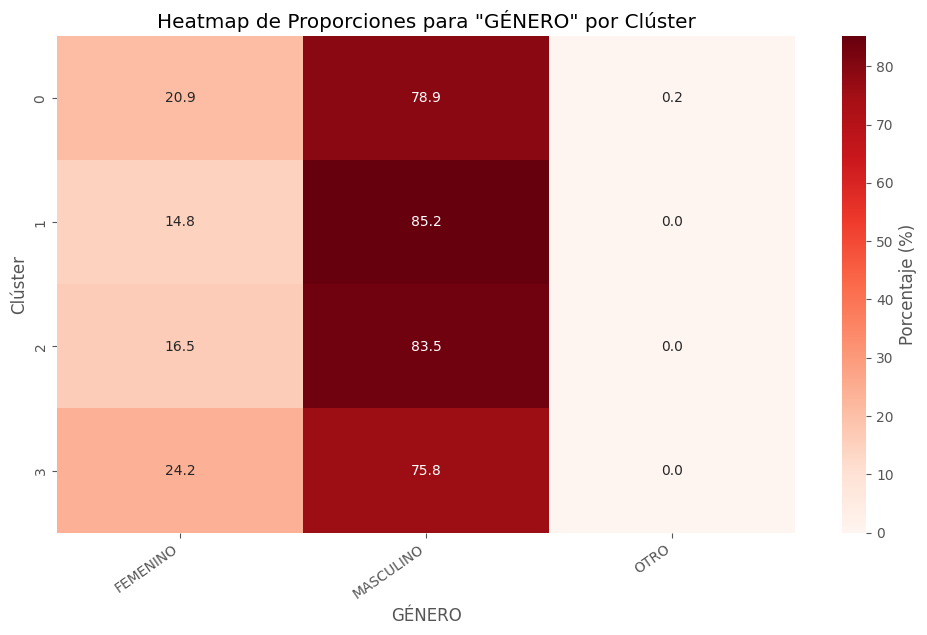

------------------------------------------------------------
Proceso completado.


In [ ]:
df_cluster['cluster'] = pd.Categorical(df_cluster['cluster'])

categorical_features = ['DELITO', 'PAIS PRISIÓN', 'GRUPO EDAD', 'GÉNERO']

def get_mode(x):
    modes = x.mode()
    if not modes.empty:
        return modes[0]
    return 'N/A'

# --- 1. Calcular y Mostrar la Moda por Cluster ---
print("--- Resumen de Clusters (Moda - Categoría Más Frecuente) ---")
cluster_mode_summary = df_cluster.groupby('cluster', observed=False)[categorical_features].agg(get_mode) # observed=False
print(cluster_mode_summary)
print("-" * 60)

# --- 2. Calcular Proporciones de Categorías por Cluster (Más Detallado) ---
print("\n--- Resumen de Clusters (Proporciones de Categorías) ---")

# Almacenaremos los DataFrames de proporciones numéricas para graficar y guardar
proportions_dataframes_numeric = {}
# Almacenaremos los DataFrames de proporciones formateadas para mostrar (opcional)
proportions_dataframes_formatted = {}


for feature in categorical_features:
    # Calcular proporciones numéricas
    feature_summary_numeric = df_cluster.groupby('cluster', observed=False)[feature] \
                                        .value_counts(normalize=True) \
                                        .mul(100).unstack(level=feature, fill_value=0)

    proportions_dataframes_numeric[feature] = feature_summary_numeric

    # Formatear como porcentaje para mejor lectura en la consola
    feature_summary_formatted = feature_summary_numeric.applymap(lambda x: f"{x:.1f}%")
    proportions_dataframes_formatted[feature] = feature_summary_formatted

    print(f"\nDistribución para la característica: '{feature}' (Numérico para guardar/graficar)")
    print(feature_summary_numeric)
    print(f"\nDistribución para la característica: '{feature}' (Formateado para mostrar)")
    print(feature_summary_formatted)

    # --- Visualización de proporciones ---

    # Opción A: Gráfico de Barras Apiladas
    # Es bueno si el número de categorías no es excesivo.
    if len(feature_summary_numeric.columns) < 15 : # Umbral para evitar gráficos muy densos
        feature_summary_numeric.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='autumn')
        plt.title(f'Proporción de Categorías para "{feature}" por Clúster')
        plt.ylabel('Porcentaje (%)')
        plt.xlabel('Clúster')
        plt.xticks(rotation=0)
        plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'barchart_proportions_{feature.lower().replace(" ", "_")}.png')
        plt.show()
    else:
        print(f"Omitiendo gráfico de barras para '{feature}' debido a demasiadas categorías ({len(feature_summary_numeric.columns)}). Considerar Heatmap.")

    # Opción B: Heatmap
    plt.figure(figsize=(max(10, len(feature_summary_numeric.columns)*0.5), max(6, len(feature_summary_numeric.index)*0.5))) # Ajustar tamaño dinámicamente
    sns.heatmap(feature_summary_numeric, annot=True, fmt=".1f", cmap="Reds", cbar_kws={'label': 'Porcentaje (%)'})
    plt.title(f'Heatmap de Proporciones para "{feature}" por Clúster')
    plt.ylabel('Clúster')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.xticks(rotation = 35, ha = 'right')
    plt.savefig(f'heatmap_proportions_{feature.lower().replace(" ", "_")}.png')
    plt.show()


print("-" * 60)

## UMAP Code

In [ ]:
# --- 2. Seleccionar Columnas y Aplicar OHE ---
features_to_encode = ['DELITO', 'PAIS PRISIÓN', 'GRUPO EDAD', 'GÉNERO']
data_to_process = df_cluster[features_to_encode]

# Usar OneHotEncoder de scikit-learn
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
data_encoded = encoder.fit_transform(data_to_process)

print(f"\nForma de los datos después de One-Hot Encoding: {data_encoded.shape}")


Forma de los datos después de One-Hot Encoding: (159695, 45)


In [ ]:
# --- 3. Instanciar y Aplicar UMAP con Métrica Binaria ---
chosen_metric =['hamming',
'jaccard',
'dice',
'russellrao',
'kulsinski',
'rogerstanimoto',
'sokalmichener',
'sokalsneath',
'yule']

In [ ]:
def metric_umap(metric='hamming', n_neighbors=5, min_dist=0.1):
  reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric=metric, random_state=42)
  embedding = reducer.fit_transform(data_encoded)

  print(f"\nForma del embedding UMAP: {embedding.shape}")

  # --- 4. Visualizar los Resultados ---
  plt.figure(figsize=(12, 8))
  scatter = sns.scatterplot(
      x=embedding[:, 0],
      y=embedding[:, 1],
      hue=df_cluster['cluster'],
      palette="plasma"
  )

  plt.title(f'Proyección UMAP con métrica "{metric} - Ng {n_neighbors} - d {min_dist}"', fontsize=16)
  plt.xlabel('Componente UMAP 1')
  plt.ylabel('Componente UMAP 2')
  plt.legend(title='Cluster Previo', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.tight_layout() # Ajusta para que la leyenda no se corte
  plt.show()

  return reducer, embedding

### Umap parameters

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Forma del embedding UMAP: (159695, 2)


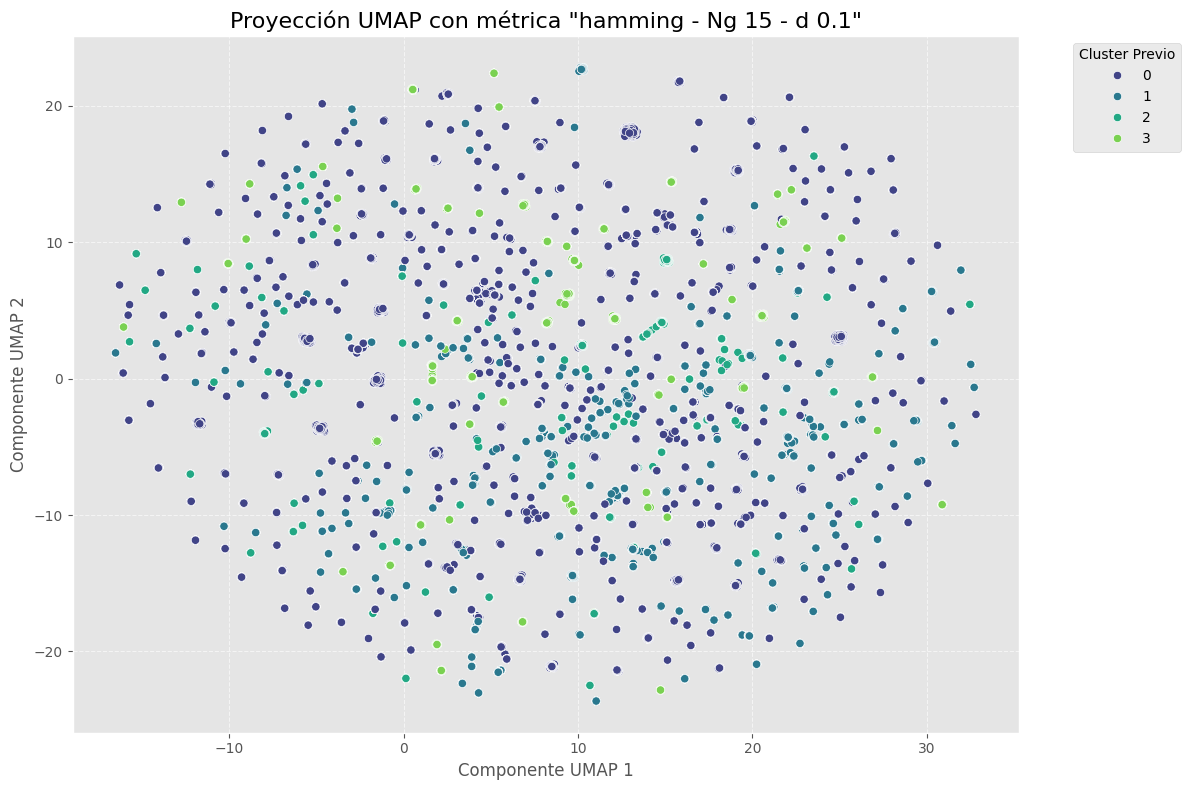

In [ ]:
metric_umap(chosen_metric[0], 15, 0.1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Forma del embedding UMAP: (159695, 2)


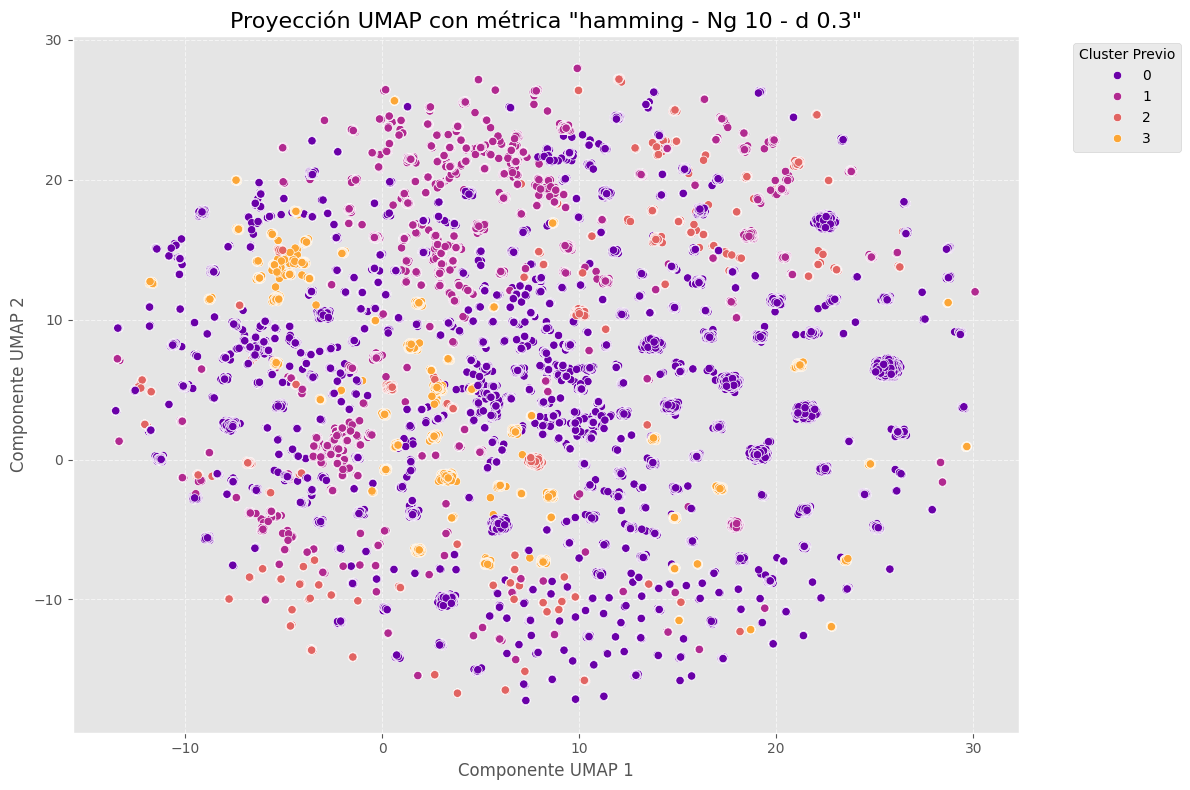

In [ ]:
reducer, embedding = metric_umap(chosen_metric[0], 10, 0.3)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Forma del embedding UMAP: (159695, 2)


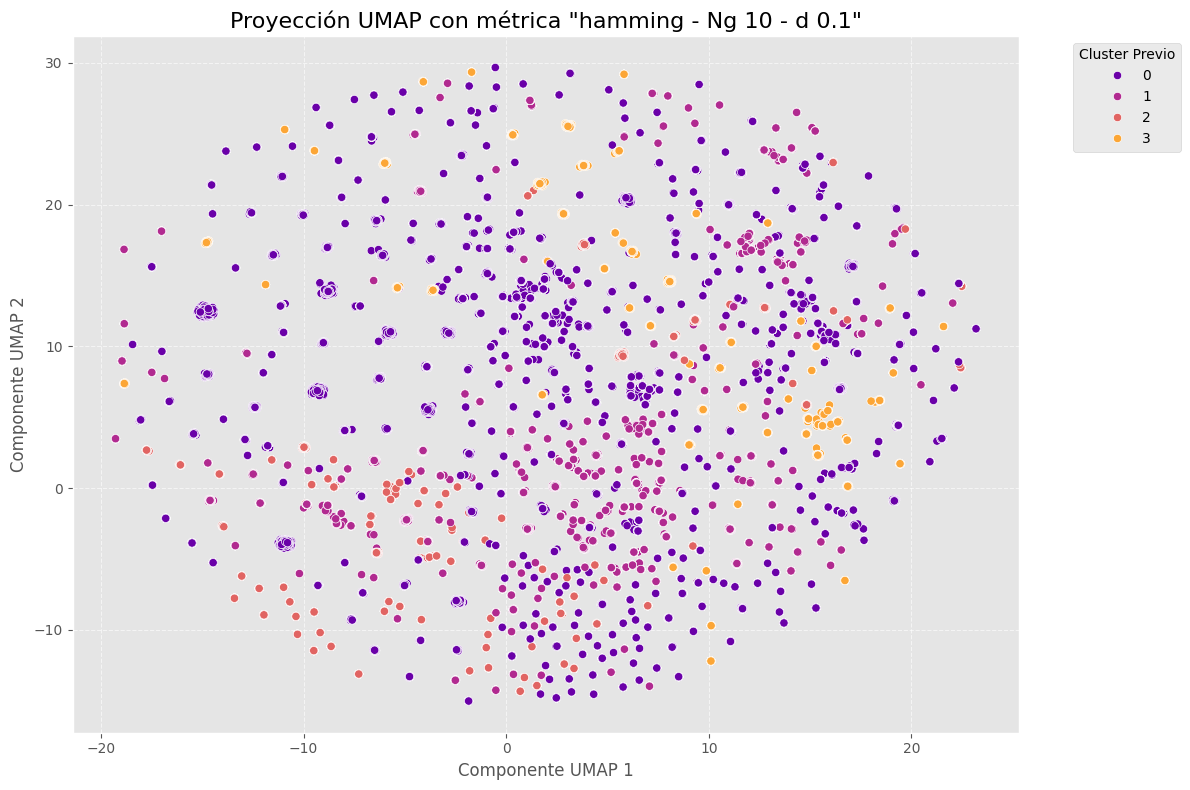

In [ ]:
metric_umap(chosen_metric[0], 10)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Forma del embedding UMAP: (159695, 2)


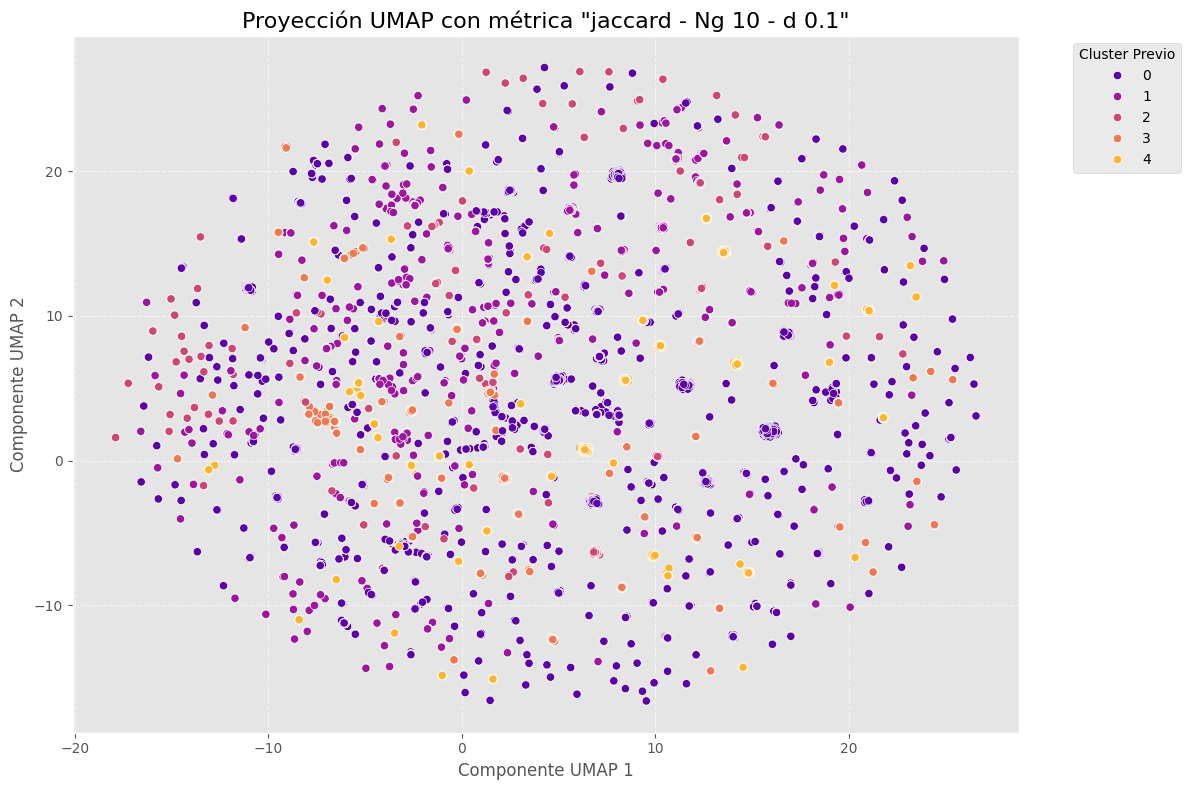

In [ ]:
metric_umap(chosen_metric[1], 10)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Forma del embedding UMAP: (159695, 2)


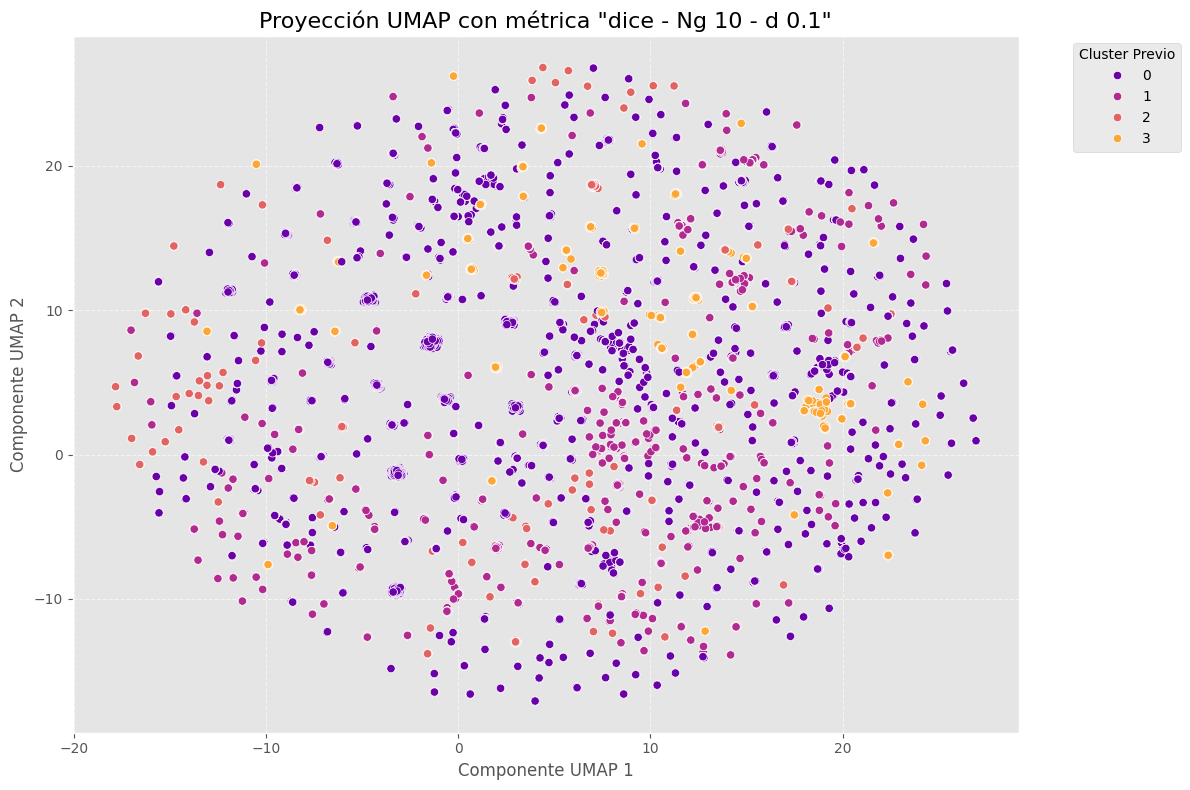

In [ ]:
metric_umap(chosen_metric[2], 10)

## Predicción por Situación Juridica

In [ ]:
df_sj = df_colombianos_presos.copy()
df_sj = df_sj[['DELITO', 'PAIS PRISIÓN', 'GRUPO EDAD', 'GÉNERO', 'SITUACIÓN JURÍDICA']]
df_sj['cluster'] = clusters_cao
df_sj = df_sj.reset_index()
df_sj = df_sj.drop('index', axis=1)
df_sj.head()

,DELITO,PAIS PRISIÓN,GRUPO EDAD,GÉNERO,SITUACIÓN JURÍDICA,cluster
0,EXTORSIÓN,ESTADOS UNIDOS,ADULTO,MASCULINO,CONDENADO,0
1,ROBO,ITALIA,ADULTO,MASCULINO,EN JUICIO,3
2,DELITO MIGRATORIO,ESTADOS UNIDOS,ADULTO,MASCULINO,EN INVESTIGACIÓN,0
3,HOMICIDIO,VENEZUELA,ADULTO,MASCULINO,EN JUICIO,0
4,ROBO,VENEZUELA,MENORES,MASCULINO,CONDENADO,0


In [ ]:
def caracteristica(caract, categoria_a_excluir=None): # Nuevo parámetro opcional
  # 1. Prepara un DataFrame para Plotly
  plot_df_temp = df_sj.copy() # Usamos una copia temporal
  plot_df_temp['UMAP_1'] = embedding[:, 0]
  plot_df_temp['UMAP_2'] = embedding[:, 1]

  if categoria_a_excluir and caract in plot_df_temp.columns:
      print(f"Excluyendo visualmente la categoría '{categoria_a_excluir}' de la característica '{caract}'.")
      plot_df_temp = plot_df_temp[plot_df_temp[caract] != categoria_a_excluir]

  # 2. Crea el gráfico interactivo
  fig = px.scatter(
      plot_df_temp,
      x='UMAP_1',
      y='UMAP_2',
      color=caract,
      hover_data=df_sj.columns,
      title='Visualización UMAP interactiva por ' + caract + (f" (excluyendo {categoria_a_excluir})" if categoria_a_excluir else ""),
      labels={'UMAP_1': 'UMAP Dimensión 1', 'UMAP_2': 'UMAP Dimensión 2'},
      template='plotly_white',
  )

  fig.update_layout(
      legend_title_text=caract,
      width=1200,
      height=800,
      autosize=False
  )

  fig.show()

In [ ]:
caracteristica('SITUACIÓN JURÍDICA')

In [ ]:
caracteristica('GÉNERO')

In [ ]:
caracteristica('GRUPO EDAD')

## Conclusión

**Perfiles de Detenidos Colombianos en el Exterior**

El objetivo de este análisis fue crear perfiles de detenidos colombianos en el exterior, basándonos en los tipos de delitos que cometieron, el país donde están encarcelados, sus grupos de edad y su género. Para ello, se utilizaron técnicas de agrupamiento (K-Modes) para identificar grupos con características similares. El análisis reveló cuatro clusters distintos, que representan perfiles específicos:

*   **Cluster 0: Narcotráfico (Principalmente Venezuela y Estados Unidos, Mayoría Masculina Adulta)**
    *   **DELITO Dominante:** `NARCOTRÁFICO` (43.6%). Este es el delito más significativo. Le siguen a distancia `HOMICIDIO` (9.6%) y `DELITOS SEXUALES` (6.7%). Otros delitos con presencia moderada incluyen `PORTE ILEGAL DE ARMAS` (4.9%) y `SECUESTRO` (4.6%).
    *   **PAÍS PRISIÓN Dominante:** `VENEZUELA` (29.8%) y `ESTADOS UNIDOS` (18.4%) son los dos países más frecuentes. También hay una presencia notable en `ECUADOR` (8.6%), `CHILE` (5.8%), `MÉXICO` (5.7%) y `ESPAÑA` (4.5%).
    *   **GRUPO EDAD:** Predominantemente `ADULTO` (75.1%), con una proporción de `ADULTO MAYOR` (13.2%) y `ADULTO JOVEN` (10.3%).
    *   **GÉNERO:** Mayoritariamente `MASCULINO` (78.9%).
    *   **Perfil Resumido:** Este clúster agrupa principalmente a individuos **masculinos adultos** detenidos por **narcotráfico**, con una fuerte presencia en prisiones de **Venezuela y Estados Unidos**.

*   **Cluster 1: Robo (Principalmente Estados Unidos, Mayoría Masculina Adulta Joven)**
    *   **DELITO Dominante:** `ROBO` (35.7%). El delito más característico. Le siguen `HOMICIDIO` (8.1%), `DELITOS SEXUALES` (7.7%) y `PORTE ILEGAL DE ARMAS` (7.1%).
    *   **PAÍS PRISIÓN Dominante:** `ESTADOS UNIDOS` (32.0%) es el país principal. Le siguen `ESPAÑA` (12.0%), `ECUADOR` (11.2%) y `MÉXICO` (10.3%).
    *   **GRUPO EDAD:** Abrumadoramente `ADULTO JOVEN` (74.2%), con una proporción significativa de `ADULTO MAYOR` (18.4%) y muy pocos `ADULTOS` (5.3%).
    *   **GÉNERO:** Mayoritariamente `MASCULINO` (85.2%), la proporción masculina más alta entre los clústeres.
    *   **Perfil Resumido:** Este clúster se caracteriza por individuos **masculinos adultos jóvenes** detenidos principalmente por **robo**, con una fuerte conexión con prisiones en **Estados Unidos**.

*   **Cluster 2: Homicidio (Principalmente España, Mayoría Masculina Adulta Mayor)**
    *   **DELITO Dominante:** `HOMICIDIO` (47.3%). El delito más frecuente y distintivo de este clúster. Le sigue, de forma importante, `NARCOTRÁFICO` (13.9%) y `DELITOS SEXUALES` (8.5%).
    *   **PAÍS PRISIÓN Dominante:** `ESPAÑA` (58.5%) es claramente el país predominante. Le siguen a distancia `VENEZUELA` (8.2%) y `ESTADOS UNIDOS` (8.1%), y `ECUADOR` (7.3%).
    *   **GRUPO EDAD:** Predominantemente `ADULTO MAYOR` (75.1%), con una proporción de `ADULTO` (17.3%) y pocos `ADULTOS JÓVENES` (7.1%).
    *   **GÉNERO:** Mayoritariamente `MASCULINO` (83.5%).
    *   **Perfil Resumido:** Este clúster se centra en individuos **masculinos adultos mayores** detenidos principalmente por **homicidio**, con una conexión abrumadora con **España**.

*   **Cluster 3: Robo (Principalmente España, Prácticamente Todos Hombres Adultos)**
    *   **DELITO Dominante:** `ROBO` (46.8%). Claramente el delito principal, sin presencia de Narcotráfico ni Homicidio en proporciones significativas. Destacan `DELITOS SEXUALES` (5.6%), `VIOLENCIA DE GÉNERO` (5.7%), `CRIMEN ORGANIZADO` (5.0%) y `DELITOS CONTRA LA ADMINISTRACIÓN PÚBLICA` (5.0%).
    *   **PAÍS PRISIÓN Dominante:** `ESPAÑA` (64.3%) es el país con la concentración más alta para este clúster. Le siguen `MÉXICO` (6.1%) y `ECUADOR` (5.6%). Notablemente, hay una ausencia total de detenciones en Venezuela y Estados Unidos para este perfil.
    *   **GRUPO EDAD:** Casi exclusivamente `ADULTO` (99.4%).
    *   **GÉNERO:** Mayoritariamente `MASCULINO` (75.8%), la proporción masculina más baja entre los clústeres, aunque sigue siendo dominante.
    *   **Perfil Resumido:** Este clúster agrupa a individuos **masculinos, casi exclusivamente adultos**, detenidos por **robo** y otros delitos como violencia de género y contra la administración pública, con una concentración muy fuerte en prisiones de **España**.

# **Aprendizaje Supervisado**

In [ ]:
df_as = df_colombianos_presos.copy()

In [ ]:
columns_ =  ['EXTRADITADO', 'EN ESPERA DE DEPORTACIÓN', 'NO REPORTA - CONFIDENCIALIDAD ESTATAL']
df_as = df_as[~df_as['SITUACIÓN JURÍDICA'].isin(columns_)]

In [ ]:
df_as = df_as[['DELITO', 'PAIS PRISIÓN', 'GRUPO EDAD', 'GÉNERO', 'SITUACIÓN JURÍDICA']]
df_as.head(10)

,DELITO,PAIS PRISIÓN,GRUPO EDAD,GÉNERO,SITUACIÓN JURÍDICA
0,EXTORSIÓN,ESTADOS UNIDOS,ADULTO,MASCULINO,CONDENADO
1,ROBO,ITALIA,ADULTO,MASCULINO,EN JUICIO
2,DELITO MIGRATORIO,ESTADOS UNIDOS,ADULTO,MASCULINO,EN INVESTIGACIÓN
3,HOMICIDIO,VENEZUELA,ADULTO,MASCULINO,EN JUICIO
4,ROBO,VENEZUELA,MENORES,MASCULINO,CONDENADO
5,NARCOTRÁFICO,ITALIA,ADULTO JOVEN,MASCULINO,CONDENADO
6,PORTE ILEGAL DE ARMAS,MÉXICO,ADULTO JOVEN,MASCULINO,CONDENADO
7,EXTORSIÓN,ECUADOR,ADULTO,MASCULINO,CONDENADO
8,NARCOTRÁFICO,ESTADOS UNIDOS,ADULTO,MASCULINO,EN INVESTIGACIÓN
9,DAÑOS,ESPAÑA,ADULTO MAYOR,MASCULINO,EN INVESTIGACIÓN


In [ ]:
# --- 1. Seleccionar Columnas y Aplicar OHE a X ---
features_for_X = ['DELITO', 'PAIS PRISIÓN', 'GRUPO EDAD', 'GÉNERO']
target_column = 'SITUACIÓN JURÍDICA'

X_categorical = df_as[features_for_X]
y_text_labels = df_as[target_column] # Variable objetivo con etiquetas de texto

encoder_X = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder_X.fit_transform(X_categorical)
# feature_names_encoded = encoder_X.get_feature_names_out(features_for_X) # Nombres de columnas OHE

print(f"\nForma de X (características) después de One-Hot Encoding: {X_encoded.shape}")


Forma de X (características) después de One-Hot Encoding: (153481, 46)


In [ ]:
# --- 2. División de Datos (Train/Test Split) ---
X_train, X_test, y_train_text, y_test_text = train_test_split(
    X_encoded,
    y_text_labels, # Usar y con etiquetas de texto para la división
    test_size=0.2,
    random_state=42,
    stratify=y_text_labels # Estratificar sobre las etiquetas de texto
)

print(f"\nForma de X_train: {X_train.shape}, Forma de y_train_text: {y_train_text.shape}")
print(f"Forma de X_test: {X_test.shape}, Forma de y_test_text: {y_test_text.shape}")


Forma de X_train: (122784, 46), Forma de y_train_text: (122784,)
Forma de X_test: (30697, 46), Forma de y_test_text: (30697,)


In [ ]:
# --- 3. Codificar la Variable Objetivo (y) con LabelEncoder ---
print("\n--- Codificando la variable objetivo y con LabelEncoder ---")
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_text)
y_test_encoded = le.transform(y_test_text)

# Guardar las clases originales y su mapeo para referencia y para el classification_report
target_names_ordered = list(le.classes_)
labels_ordered_numeric = le.transform(target_names_ordered) # Esto será [0, 1, 2, 3, 4] si hay 5 clases

print(f"Forma de y_train_encoded: {y_train_encoded.shape}")
print(f"Forma de y_test_encoded: {y_test_encoded.shape}")
print("Clases originales mapeadas por LabelEncoder:", dict(zip(le.classes_, le.transform(le.classes_))))
print("Distribución de y_train_encoded (numérico):")
# Para ver la distribución de las etiquetas numéricas:
unique_labels_train, counts_train = np.unique(y_train_encoded, return_counts=True)
for label_num, count in zip(unique_labels_train, counts_train):
    print(f"  {le.inverse_transform([label_num])[0]} (Encoded: {label_num}): {count} ({count/len(y_train_encoded)*100:.2f}%)")


--- Codificando la variable objetivo y con LabelEncoder ---
Forma de y_train_encoded: (122784,)
Forma de y_test_encoded: (30697,)
Clases originales mapeadas por LabelEncoder: {'CONDENADO': np.int64(0), 'EN INVESTIGACIÓN': np.int64(1), 'EN JUICIO': np.int64(2)}
Distribución de y_train_encoded (numérico):
  CONDENADO (Encoded: 0): 60945 (49.64%)
  EN INVESTIGACIÓN (Encoded: 1): 42624 (34.71%)
  EN JUICIO (Encoded: 2): 19215 (15.65%)


In [ ]:
# --- 3. Manejo del Desbalance con SMOTE ---
print("\n--- Aplicando SMOTE al conjunto de entrenamiento ---")
print("Distribución de y_train ANTES de SMOTE:")

# Puedes experimentar con k_neighbors, pero el valor por defecto (5) suele ser un buen inicio
smote = SMOTE(random_state=42, k_neighbors=5)

X_train_to_use, y_train_to_use_encoded = smote.fit_resample(X_train, y_train_encoded) # Usar X_train aquí

print(f"Forma de X_train después de SMOTE: {X_train_to_use.shape}")
print("\nDistribución de y_train DESPUÉS de SMOTE:")
unique_labels_smote, counts_smote = np.unique(y_train_to_use_encoded, return_counts=True)
for label_num, count in zip(unique_labels_smote, counts_smote):
  print(f"  {le.inverse_transform([label_num])[0]} (Encoded: {label_num}): {count} ({count/len(y_train_to_use_encoded)*100:.2f}%)")



--- Aplicando SMOTE al conjunto de entrenamiento ---
Distribución de y_train ANTES de SMOTE:
Forma de X_train después de SMOTE: (182835, 46)

Distribución de y_train DESPUÉS de SMOTE:
  CONDENADO (Encoded: 0): 60945 (33.33%)
  EN INVESTIGACIÓN (Encoded: 1): 60945 (33.33%)
  EN JUICIO (Encoded: 2): 60945 (33.33%)



--- Entrenando y evaluando: RF_bal_subsample_100 ---

Informe de Clasificación:
                  precision    recall  f1-score   support

       CONDENADO       0.71      0.54      0.61     15237
EN INVESTIGACIÓN       0.63      0.48      0.55     10656
       EN JUICIO       0.32      0.73      0.44      4804

        accuracy                           0.55     30697
       macro avg       0.55      0.58      0.53     30697
    weighted avg       0.62      0.55      0.56     30697

Matriz de Confusión:


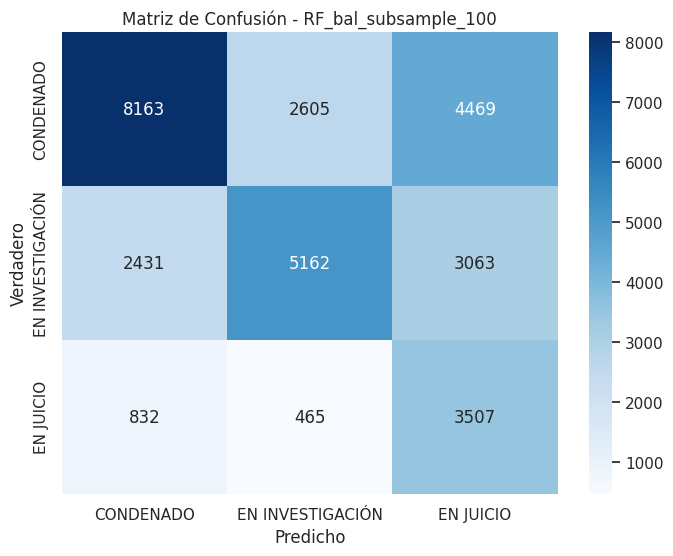

Balanced Accuracy: 0.5834
Cohen's Kappa: 0.3217

--- Entrenando y evaluando: RF_balanced_200 ---

Informe de Clasificación:
                  precision    recall  f1-score   support

       CONDENADO       0.71      0.54      0.61     15237
EN INVESTIGACIÓN       0.63      0.48      0.55     10656
       EN JUICIO       0.32      0.73      0.44      4804

        accuracy                           0.55     30697
       macro avg       0.55      0.58      0.53     30697
    weighted avg       0.62      0.55      0.56     30697

Matriz de Confusión:


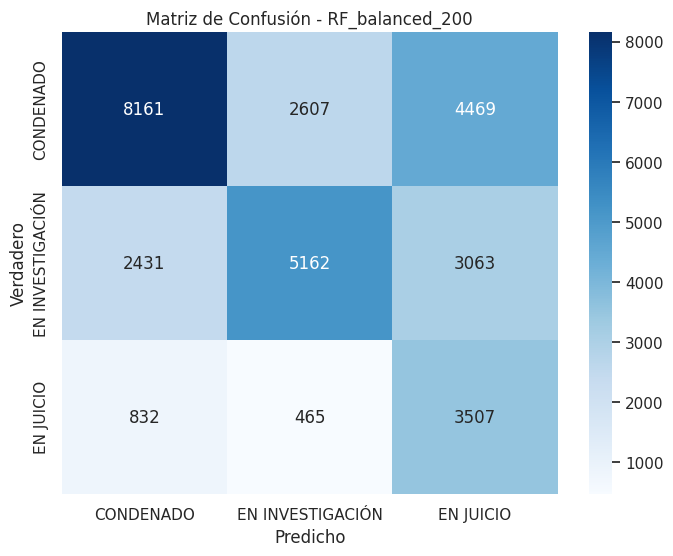

Balanced Accuracy: 0.5833
Cohen's Kappa: 0.3216

--- Entrenando y evaluando: RF_bal_subsample_100_split5_leaf2 ---

Informe de Clasificación:
                  precision    recall  f1-score   support

       CONDENADO       0.72      0.53      0.61     15237
EN INVESTIGACIÓN       0.62      0.50      0.55     10656
       EN JUICIO       0.32      0.73      0.44      4804

        accuracy                           0.55     30697
       macro avg       0.55      0.58      0.54     30697
    weighted avg       0.62      0.55      0.56     30697

Matriz de Confusión:


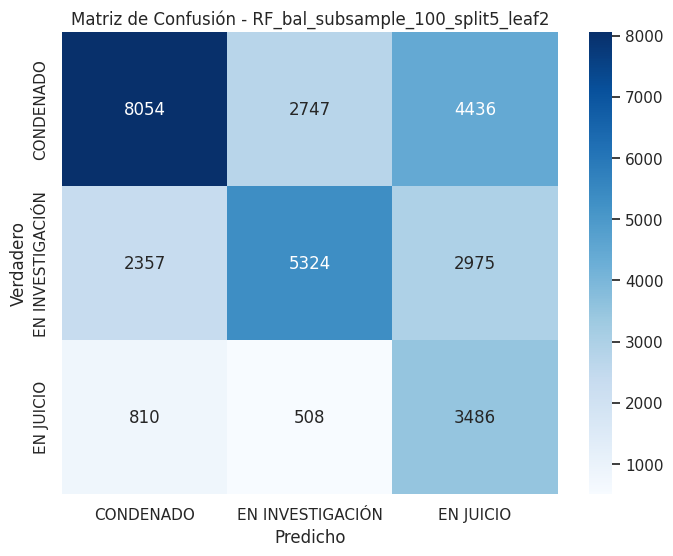

Balanced Accuracy: 0.5846
Cohen's Kappa: 0.3234


In [ ]:
# --- Tu diccionario 'models' con las configuraciones de RandomForestClassifier ---
models = {
    # --- Variando n_estimators con class_weight='balanced_subsample' y profundidad por defecto ---
    "RF_bal_subsample_100": RandomForestClassifier(
        class_weight='balanced_subsample',
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    # --- Comparando class_weight con n_estimators=200 y profundidad por defecto ---
    "RF_balanced_200": RandomForestClassifier(
        class_weight='balanced',
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),

    # --- Explorando min_samples_split y min_samples_leaf (regularización) ---
    "RF_bal_subsample_100_split5_leaf2": RandomForestClassifier(
        class_weight='balanced_subsample',
        n_estimators=100,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
}

results = {}

for model_name, model in models.items():
    print(f"\n--- Entrenando y evaluando: {model_name} ---")

    # Entrenar el modelo usando las etiquetas y codificadas numéricamente
    model.fit(X_train_to_use, y_train_to_use_encoded)

    # Realizar predicciones en el conjunto de prueba
    y_pred_encoded = model.predict(X_test) # <--- Las predicciones serán numéricas

    # Evaluar el modelo usando las etiquetas y de prueba codificadas numéricamente
    print("\nInforme de Clasificación:")
    report = classification_report(
        y_test_encoded,
        y_pred_encoded,
        labels=labels_ordered_numeric, # Usar las etiquetas numéricas para 'labels'
        target_names=target_names_ordered, # Usar los nombres originales para 'target_names'
        zero_division=0
    )
    print(report)

    print("Matriz de Confusión:")
    cm = confusion_matrix(y_test_encoded, y_pred_encoded, labels=labels_ordered_numeric)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_ordered, yticklabels=target_names_ordered)
    plt.xlabel('Predicho')
    plt.ylabel('Verdadero')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()


    bal_acc = balanced_accuracy_score(y_test_encoded, y_pred_encoded)
    print(f"Balanced Accuracy: {bal_acc:.4f}")

    kappa = cohen_kappa_score(y_test_encoded, y_pred_encoded)
    print(f"Cohen's Kappa: {kappa:.4f}")

    results[model_name] = {
        'model': model,
        'classification_report': report,
        'confusion_matrix': cm,
        'balanced_accuracy': bal_acc,
        'cohen_kappa': kappa
    }

## Conclusiones

Este entrenamiento supervisado tuvo como objetivo principal evaluar la viabilidad de predecir la situación jurídica de detenidos, utilizando un conjunto de características que incluyen el tipo de `DELITO`, `PAIS PRISIÓN`, `GRUPO EDAD` y `GÉNERO`. La variable objetivo, `SITUACIÓN JURÍDICA`, se consolidó en tres categorías principales para este análisis predictivo: `CONDENADO`, `EN INVESTIGACIÓN` y `EN JUICIO`.

### **Metodología y Preprocesamiento Clave:**

1.  **Selección y Agrupación de Clases Objetivo:**
    *   Se enfocó el análisis en las tres situaciones jurídicas más representativas: `CONDENADO`, `EN INVESTIGACIÓN` y `EN JUICIO`.
    *   Clases como "EXTRADITADO", "EN ESPERA DE DEPORTACIÓN" y "NO REPORTA - CONFIDENCIALIDAD ESTATAL" fueron excluidas por tener una baja cantidad de datos con respecto a las otras 3 categoríass.
2.  **Filtrado de `PAIS PRISIÓN`:** Solo se consideraron países de prisión con más de 10,000 detenidos registrados, para asegurar un soporte suficiente en esta característica.
3.  **Codificación de Características:**
    *   Variables categóricas de entrada (X): Transformadas mediante One-Hot Encoding.
    *   Variable objetivo (Y): Codificada numéricamente usando Label Encoding, resultando en el siguiente mapeo y distribución en el conjunto de entrenamiento (antes de SMOTE):

| Clase Original     | Encoding | # Muestras (Train) | % (Train) |
| :----------------- | :------- | :----------------- | :-------- |
| CONDENADO          | 0        | 60945              | 49.64%    |
| EN INVESTIGACIÓN   | 1        | 42624              | 34.71%    |
| EN JUICIO          | 2        | 19215              | 15.65%    |
| **Total Train**    |          | **122784**         |           |

4.  **Manejo del Desbalance de Clases con SMOTE:**
    *   Dada la distribución desigual de las clases objetivo, se aplicó la técnica **SMOTE (Synthetic Minority Over-sampling Technique)** exclusivamente al conjunto de entrenamiento.
    *   **Propósito de SMOTE:** SMOTE ayuda a balancear el conjunto de datos creando muestras sintéticas de las clases minoritarias. Esto permite que el modelo de aprendizaje no esté sesgado hacia la predicción de la clase mayoritaria y tenga una mejor oportunidad de aprender los patrones distintivos de todas las clases, incluidas las menos frecuentes.
    *   Después de aplicar SMOTE, la distribución en el conjunto de entrenamiento se balanceó:

| Clase Original     | Encoding | # Muestras (Train SMOTE) | % (Train SMOTE) |
| :----------------- | :------- | :----------------------- | :-------------- |
| CONDENADO          | 0        | 60945                    | 33.33%          |
| EN INVESTIGACIÓN   | 1        | 60945                    | 33.33%          |
| EN JUICIO          | 2        | 60945                    | 33.33%          |
| **Total Train SMOTE**|          | **182835**               |                 |

### **Resultados Destacados del Modelo `RandomForestClassifier`**

Se evaluaron diversas configuraciones del algoritmo `RandomForestClassifier`. Los resultados fueron notablemente consistentes, indicando que el modelo alcanzó un techo de rendimiento con las características y el preprocesamiento aplicados. A continuación, se presentan las métricas representativas de las configuraciones más robustas (ej. `RF_bal_subsample_100_est_split5_leaf2`):

| Métrica Global         | Valor Aproximado |
| :--------------------- | :--------------- |
| Accuracy General       | 0.55             |
| Balanced Accuracy      | 0.583            |
| Macro Average F1-score | 0.54             |
| Cohen's Kappa          | 0.31             |

**Informe de Clasificación Detallado (Representativo):**

| Clase            | Precision | Recall | F1-score | Support (Test Set) |
| :--------------- | :-------- | :----- | :------- | :----------------- |
| CONDENADO        | 0.72      | 0.53   | 0.61     | 15237              |
| EN INVESTIGACIÓN | 0.62      | 0.50   | 0.55     | 10656              |
| EN JUICIO        | 0.32      | 0.73   | 0.44     | 4804               |
|                  |           |        |          |                    |
| **Macro Avg**    | **0.55**  | **0.58** | **0.54** | **30697**          |
| **Weighted Avg** | **0.62**  | **0.55** | **0.56** | **30697**          |

**Análisis de la Matriz de Confusión (Ejemplo visualizado):**

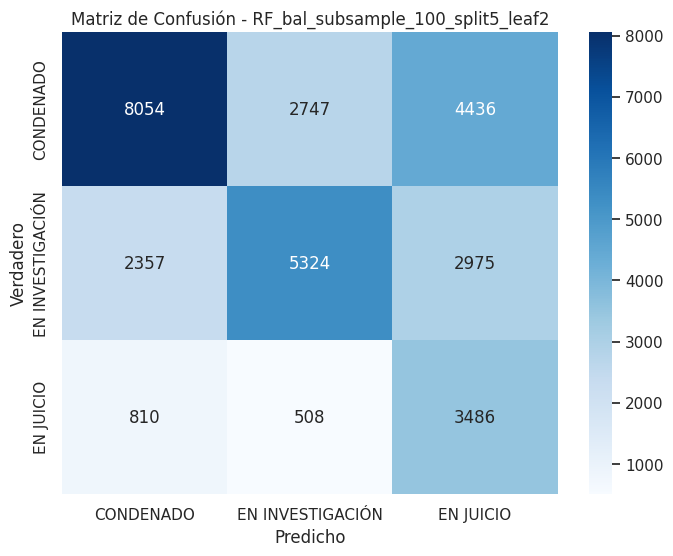

*   **Clase `CONDENADO`:** Presenta la precisión más alta (0.72), pero un recall moderado (0.53), siendo confundida principalmente con `EN JUICIO`.
*   **Clase `EN INVESTIGACIÓN`:** Muestra un balance moderado entre precisión (0.62) y recall (0.50).
*   **Clase `EN JUICIO`:** Logra el recall más alto (0.73), pero con la precisión más baja (0.32), indicando una alta tasa de falsos positivos.

### Interpretación de la Métrica Cohen's Kappa

La **Métrica Cohen's Kappa (κ)** mide el grado de acuerdo entre las clases predichas por el modelo y las clases reales, corrigiendo la posibilidad de que el acuerdo ocurra únicamente por azar. Un valor de 1 indica acuerdo perfecto, 0 acuerdo igual al azar, y valores negativos un acuerdo peor que el azar.
Los valores de Kappa se pueden interpretar cualitativamente:
*   < 0.00: Pobre
*   0.00 - 0.20: Leve
*   **0.21 - 0.40: Aceptable / Justo**
*   0.41 - 0.60: Moderado
*   0.61 - 0.80: Sustancial
*   0.81 - 1.00: Casi perfecto / Perfecto

En nuestro caso, un **Cohen's Kappa consistentemente alrededor de 0.31** (para los mejores Random Forest con 3 clases y SMOTE) indica un **acuerdo "Aceptable" o "Justo"** entre las predicciones del modelo y la realidad, más allá de lo que se lograría por simple azar. Si bien esto demuestra que el modelo ha aprendido patrones genuinos, también subraya que hay un margen considerable para la mejora.

### Conclusión Principal del Análisis de Machine Learning

El análisis de aprendizaje supervisado, enfocado en predecir la situación jurídica agrupada en tres categorías (`CONDENADO`, `EN INVESTIGACIÓN`, y `EN JUICIO`), demuestra que los modelos, incluso con técnicas de balanceo como SMOTE y optimización de hiperparámetros, alcanzan un **rendimiento predictivo moderado**.

Las métricas obtenidas (Balanced Accuracy ~0.58, Cohen's Kappa ~0.31, Macro F1-score ~0.54) sugieren que si bien los modelos son capaces de identificar ciertas tendencias y superan una clasificación aleatoria, existe una **superposición significativa en los perfiles de características** (`DELITO`, `PAIS PRISIÓN` filtrado/agrupado, `GRUPO EDAD`, `GÉNERO`) de los individuos en estas diferentes situaciones jurídicas. Esta superposición limita la capacidad de los modelos para distinguir con alta precisión y recall todas las clases de manera balanceada.

**Este estudio subraya una conclusión fundamental: para lograr una mejora sustancial en la predicción de la situación jurídica, es altamente probable que se requieran características adicionales y/o datos más granulares.** Variables como:
*   Tiempo transcurrido desde la detención
*   Antecedentes delictivos previos del individuo
*   Tipo y calidad de la representación legal
*   Información socioeconómica más detallada

podrían aportar la señal predictiva necesaria que actualmente no está capturada en el conjunto de datos utilizado.
